# 📈 Modelos Tradicionales de Regresión
## Trabajo Final - Inteligencia de Negocios 2025

**Maestría en Economía Aplicada - UBA**  
**Dataset:** Inmuebles procesado y filtrado

### Objetivos del Notebook
1. **Implementar Regresión Lineal múltiple**
2. **Desarrollar modelo LASSO con regularización**
3. **Analizar interpretabilidad económica de coeficientes**
4. **Establecer baseline para modelos avanzados**
5. **Comparar rendimiento predictivo**

---

## 📦 Configuración Inicial

In [27]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yaml  # Para guardar resultados en YAML
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

print("✅ Configuración completada")
print("💾 PyYAML cargado para guardado de resultados en YAML")

✅ Configuración completada
💾 PyYAML cargado para guardado de resultados en YAML


In [28]:
# 🔧 FUNCIÓN UTILITARIA PARA GUARDADO YAML INCREMENTAL
def save_result_to_yaml(resultado, yaml_path='resultados_modelos_tradicionales.yaml'):
    """
    Guarda resultados de forma incremental en archivo YAML.
    Evita duplicados basándose en la clave 'modelo' o claves principales.
    
    Parameters:
    -----------
    resultado : dict
        Diccionario con los resultados a guardar
    yaml_path : str
        Ruta del archivo YAML
    """
    import yaml
    import copy
    
    def convert_tuples_to_lists(obj):
        """Convierte tuplas a listas para compatibilidad YAML"""
        if isinstance(obj, dict):
            return {k: convert_tuples_to_lists(v) for k, v in obj.items()}
        elif isinstance(obj, tuple):
            return list(obj)
        elif isinstance(obj, list):
            return [convert_tuples_to_lists(i) for i in obj]
        else:
            return obj
    
    # Leer archivo existente o crear lista vacía
    try:
        with open(yaml_path, 'r', encoding='utf-8') as f:
            data = yaml.safe_load(f) or []
    except FileNotFoundError:
        data = []
    
    # Asegurar que data es una lista
    if not isinstance(data, list):
        data = [data]
    
    # Convertir tuplas a listas para compatibilidad YAML
    resultado_clean = convert_tuples_to_lists(copy.deepcopy(resultado))
    
    # Identificar tipo de entrada y evitar duplicados
    if 'modelo' in resultado_clean:
        # Es un modelo individual
        modelo_nombre = resultado_clean['modelo']
        data = [d for d in data if d.get('modelo') != modelo_nombre]
        print(f"💾 Guardando modelo: {modelo_nombre}")
    elif 'comparacion_tradicionales' in resultado_clean:
        # Es un resumen comparativo
        data = [d for d in data if 'comparacion_tradicionales' not in d]
        print(f"💾 Guardando resumen comparativo")
    else:
        # Otro tipo de entrada
        print(f"💾 Guardando entrada personalizada")
    
    # Agregar nuevo resultado
    data.append(resultado_clean)
    
    # Guardar archivo
    with open(yaml_path, 'w', encoding='utf-8') as f:
        yaml.dump(data, f, allow_unicode=True, sort_keys=False, indent=2)
    
    print(f"✅ Resultados guardados en {yaml_path}")
    print(f"📊 Total de entradas en archivo: {len(data)}")

print("🔧 Función de guardado YAML centralizada creada")

🔧 Función de guardado YAML centralizada creada


## 🔍 1. Carga y Preparación de Datos

In [29]:
# Cargar dataset procesado de la notebook anterior
df = pd.read_csv('train_bi_2025_filtered.csv')

print("📋 DATASET CARGADO")
print("=" * 40)
print(f"Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"Tamaño en memoria: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Verificar estructura del dataset
print(f"\n📊 ESTRUCTURA DEL DATASET:")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numéricas ({len(numeric_cols)}): {numeric_cols}")
print(f"Variables categóricas ({len(categorical_cols)}): {categorical_cols}")

# Mostrar estadísticas básicas del target
print(f"\n💰 VARIABLE OBJETIVO (PRICE):")
print(f"Promedio: ${df['price'].mean():,.0f}")
print(f"Mediana:  ${df['price'].median():,.0f}")
print(f"Rango:    ${df['price'].min():,.0f} - ${df['price'].max():,.0f}")

📋 DATASET CARGADO
Dimensiones: 311,660 filas × 15 columnas
Tamaño en memoria: 377.8 MB

📊 ESTRUCTURA DEL DATASET:
Variables numéricas (11): ['lat', 'lon', 'rooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'created_year', 'created_month', 'created_quarter', 'created_weekday']
Variables categóricas (4): ['l2', 'l3', 'prop_type', 'description']

💰 VARIABLE OBJETIVO (PRICE):
Promedio: $160,807
Mediana:  $139,100
Rango:    $2,170 - $488,274


### 1.1 Preparación de Features

In [30]:
def prepare_features(df):
    """
    Prepara las features para modelado excluyendo coordenadas y 
    aplicando encoding a variables categóricas.
    
    NOTA: Excluye 'description' para evitar problemas de memoria
    con demasiadas variables dummy.
    
    Returns:
    --------
    X : DataFrame
        Features preparadas para modelado
    y : Series
        Variable objetivo
    feature_info : dict
        Información sobre las features procesadas
    """
    # Excluir coordenadas geográficas, target y description (para evitar memory error)
    exclude_cols = ['lat', 'lon', 'price', 'description']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Separar features y target
    X = df[feature_cols].copy()
    y = df['price'].copy()
    
    # Identificar tipos de variables
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"🔢 Variables numéricas ({len(numerical_cols)}): {numerical_cols}")
    print(f"🏷️ Variables categóricas ({len(categorical_cols)}): {categorical_cols}")
    
    # Aplicar encoding one-hot a variables categóricas
    if len(categorical_cols) > 0:
        X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
        print(f"✅ Variables categóricas convertidas a {X_encoded.shape[1] - len(numerical_cols)} variables dummy")
    else:
        X_encoded = X.copy()
        print("ℹ️ No hay variables categóricas para convertir")
    
    # Información del procesamiento
    feature_info = {
        'original_features': len(feature_cols),
        'encoded_features': X_encoded.shape[1],
        'numerical_vars': len(numerical_cols),
        'categorical_vars': len(categorical_cols),
        'dummy_vars_created': X_encoded.shape[1] - len(numerical_cols)
    }
    
    return X_encoded, y, feature_info

# Preparar datos
X, y, feature_info = prepare_features(df)

print("🔧 PREPARACIÓN DE FEATURES COMPLETADA")
print("=" * 50)
print(f"Features originales:      {feature_info['original_features']}")
print(f"Features codificadas:     {feature_info['encoded_features']}")
print(f"Variables numéricas:      {feature_info['numerical_vars']}")
print(f"Variables categóricas:    {feature_info['categorical_vars']}")
print(f"Variables dummy creadas:  {feature_info['dummy_vars_created']}")

print(f"\n📊 DATASET FINAL PARA MODELADO:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

🔢 Variables numéricas (8): ['rooms', 'bathrooms', 'surface_total', 'surface_covered', 'created_year', 'created_month', 'created_quarter', 'created_weekday']
🏷️ Variables categóricas (3): ['l2', 'l3', 'prop_type']
✅ Variables categóricas convertidas a 85 variables dummy
🔧 PREPARACIÓN DE FEATURES COMPLETADA
Features originales:      11
Features codificadas:     93
Variables numéricas:      8
Variables categóricas:    3
Variables dummy creadas:  85

📊 DATASET FINAL PARA MODELADO:
X shape: (311660, 93)
y shape: (311660,)
✅ Variables categóricas convertidas a 85 variables dummy
🔧 PREPARACIÓN DE FEATURES COMPLETADA
Features originales:      11
Features codificadas:     93
Variables numéricas:      8
Variables categóricas:    3
Variables dummy creadas:  85

📊 DATASET FINAL PARA MODELADO:
X shape: (311660, 93)
y shape: (311660,)


### 1.2 División Train/Test y Estandarización

In [31]:
# División estratificada de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print("📊 DIVISIÓN DE DATOS")
print("=" * 30)
print(f"Entrenamiento: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Prueba:        {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Features:      {X_train.shape[1]} variables")

# Estandarización para modelos que lo requieren (LASSO)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ ESTANDARIZACIÓN COMPLETADA:")
print(f"Media features escaladas:    {X_train_scaled.mean():.6f}")
print(f"Desv. std features escaladas: {X_train_scaled.std():.6f}")

# Verificar distribución del target en train/test
print(f"\n💰 DISTRIBUCIÓN DEL TARGET:")
print(f"Train - Promedio: ${y_train.mean():,.0f}, Std: ${y_train.std():,.0f}")
print(f"Test  - Promedio: ${y_test.mean():,.0f}, Std: ${y_test.std():,.0f}")

📊 DIVISIÓN DE DATOS
Entrenamiento: 249,328 muestras (80.0%)
Prueba:        62,332 muestras (20.0%)
Features:      93 variables

✅ ESTANDARIZACIÓN COMPLETADA:
Media features escaladas:    0.000000
Desv. std features escaladas: 1.000000

💰 DISTRIBUCIÓN DEL TARGET:
Train - Promedio: $160,893, Std: $83,226
Test  - Promedio: $160,460, Std: $82,447

✅ ESTANDARIZACIÓN COMPLETADA:
Media features escaladas:    0.000000
Desv. std features escaladas: 1.000000

💰 DISTRIBUCIÓN DEL TARGET:
Train - Promedio: $160,893, Std: $83,226
Test  - Promedio: $160,460, Std: $82,447


## 📈 2. Modelo de Regresión Lineal Múltiple

### 2.1 Entrenamiento y Evaluación

In [32]:
# Entrenar modelo de regresión lineal
print("🔄 ENTRENANDO REGRESIÓN LINEAL")
print("=" * 40)

lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(X_train, y_train)

# Generar predicciones
y_pred_train_lr = lr_model.predict(X_train)
y_pred_test_lr = lr_model.predict(X_test)

# Calcular métricas
def calculate_metrics(y_true, y_pred, set_name=""):
    """Calcula métricas de evaluación para regresión"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        f'RMSE_{set_name}': rmse,
        f'MAE_{set_name}': mae,
        f'R2_{set_name}': r2
    }

# Métricas regresión lineal
lr_metrics_train = calculate_metrics(y_train, y_pred_train_lr, "Train")
lr_metrics_test = calculate_metrics(y_test, y_pred_test_lr, "Test")

print("📊 RESULTADOS REGRESIÓN LINEAL")
print("=" * 40)
print(f"RMSE Entrenamiento: ${lr_metrics_train['RMSE_Train']:,.0f}")
print(f"RMSE Prueba:        ${lr_metrics_test['RMSE_Test']:,.0f}")
print(f"MAE Entrenamiento:  ${lr_metrics_train['MAE_Train']:,.0f}")
print(f"MAE Prueba:         ${lr_metrics_test['MAE_Test']:,.0f}")
print(f"R² Entrenamiento:   {lr_metrics_train['R2_Train']:.4f}")
print(f"R² Prueba:          {lr_metrics_test['R2_Test']:.4f}")

# Análisis de overfitting
overfitting_ratio_lr = lr_metrics_test['RMSE_Test'] / lr_metrics_train['RMSE_Train']
print(f"Ratio Overfitting:  {overfitting_ratio_lr:.3f}")

if overfitting_ratio_lr < 1.05:
    print("✅ Bajo riesgo de overfitting")
elif overfitting_ratio_lr < 1.15:
    print("⚠️ Overfitting moderado")
else:
    print("🚨 Alto riesgo de overfitting")

# Guardar resultados y metadatos en YAML usando función centralizada
resultados_lr = {
    'modelo': 'Regresión Lineal',
    'tipo': 'tradicional',
    'hiperparametros': {'n_jobs': -1},
    'n_features': X.shape[1],
    'metricas': {
        'train': {
            'RMSE': float(lr_metrics_train['RMSE_Train']),
            'MAE': float(lr_metrics_train['MAE_Train']),
            'R2': float(lr_metrics_train['R2_Train'])
        },
        'test': {
            'RMSE': float(lr_metrics_test['RMSE_Test']),
            'MAE': float(lr_metrics_test['MAE_Test']),
            'R2': float(lr_metrics_test['R2_Test'])
        },
        'overfitting_ratio': float(overfitting_ratio_lr)
    },
    'notebook': '02_modelos_tradicionales.ipynb'
}

# Guardar usando función centralizada
save_result_to_yaml(resultados_lr)

🔄 ENTRENANDO REGRESIÓN LINEAL
📊 RESULTADOS REGRESIÓN LINEAL
RMSE Entrenamiento: $43,357
RMSE Prueba:        $42,960
MAE Entrenamiento:  $31,156
MAE Prueba:         $30,922
R² Entrenamiento:   0.7286
R² Prueba:          0.7285
Ratio Overfitting:  0.991
✅ Bajo riesgo de overfitting
💾 Guardando modelo: Regresión Lineal
✅ Resultados guardados en resultados_modelos_tradicionales.yaml
📊 Total de entradas en archivo: 3
📊 RESULTADOS REGRESIÓN LINEAL
RMSE Entrenamiento: $43,357
RMSE Prueba:        $42,960
MAE Entrenamiento:  $31,156
MAE Prueba:         $30,922
R² Entrenamiento:   0.7286
R² Prueba:          0.7285
Ratio Overfitting:  0.991
✅ Bajo riesgo de overfitting
💾 Guardando modelo: Regresión Lineal
✅ Resultados guardados en resultados_modelos_tradicionales.yaml
📊 Total de entradas en archivo: 3


### 2.2 Análisis de Coeficientes e Interpretabilidad Económica

In [33]:
# Análisis detallado de coeficientes
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': lr_model.coef_,
    'Abs_Coef': np.abs(lr_model.coef_)
}).sort_values('Abs_Coef', ascending=False)

print("🔍 ANÁLISIS DE COEFICIENTES - REGRESIÓN LINEAL")
print("=" * 60)
print(f"Intercepto: ${lr_model.intercept_:,.0f}")

# Top 15 coeficientes más importantes
print(f"\n📊 TOP 15 VARIABLES MÁS INFLUYENTES:")
top_15_coef = coef_df.head(15)
for idx, row in top_15_coef.iterrows():
    signo = "+" if row['Coeficiente'] > 0 else ""
    print(f"{row['Variable']:25} {signo}${row['Coeficiente']:8,.0f}")

# Análisis por categorías
print(f"\n🏘️ ANÁLISIS POR CATEGORÍAS:")

# Variables geográficas (l3)
geo_vars = coef_df[coef_df['Variable'].str.contains('l3_', na=False)].copy()
if len(geo_vars) > 0:
    top_geo_pos = geo_vars[geo_vars['Coeficiente'] > 0].nlargest(3, 'Coeficiente')
    top_geo_neg = geo_vars[geo_vars['Coeficiente'] < 0].nsmallest(3, 'Coeficiente')
    
    print(f"📍 Barrios con mayor premium:")
    for _, row in top_geo_pos.iterrows():
        barrio = row['Variable'].replace('l3_', '').replace('_', ' ').title()
        print(f"  • {barrio}: +${row['Coeficiente']:,.0f}")
    
    print(f"📍 Barrios con mayor descuento:")
    for _, row in top_geo_neg.iterrows():
        barrio = row['Variable'].replace('l3_', '').replace('_', ' ').title()
        print(f"  • {barrio}: ${row['Coeficiente']:,.0f}")

# Variables de tipo de propiedad
prop_vars = coef_df[coef_df['Variable'].str.contains('prop_type_', na=False)].copy()
if len(prop_vars) > 0:
    print(f"\n🏢 Tipos de propiedad más relevantes:")
    top_prop = prop_vars.nlargest(3, 'Abs_Coef')
    for _, row in top_prop.iterrows():
        tipo = row['Variable'].replace('prop_type_', '').replace('_', ' ').title()
        signo = "+" if row['Coeficiente'] > 0 else ""
        print(f"  • {tipo}: {signo}${row['Coeficiente']:,.0f}")

# Variables numéricas más importantes
num_vars = coef_df[~coef_df['Variable'].str.contains('l3_|prop_type_|l2_', na=False)].copy()
top_num = num_vars.nlargest(5, 'Abs_Coef')
print(f"\n📏 Variables numéricas más importantes:")
for _, row in top_num.iterrows():
    signo = "+" if row['Coeficiente'] > 0 else ""
    print(f"  • {row['Variable']:20} {signo}${row['Coeficiente']:8,.0f}")

# Análisis de significancia práctica
significant_coefs = coef_df[coef_df['Abs_Coef'] > 10000]
print(f"\n💡 SIGNIFICANCIA PRÁCTICA:")
print(f"Variables con impacto > $10,000: {len(significant_coefs)}/{len(coef_df)} ({len(significant_coefs)/len(coef_df)*100:.1f}%)")
print(f"Estas variables son las más relevantes económicamente")

🔍 ANÁLISIS DE COEFICIENTES - REGRESIÓN LINEAL
Intercepto: $2,299,402

📊 TOP 15 VARIABLES MÁS INFLUYENTES:
l3_Puerto Madero          +$ 178,390
l3_Villa Soldati          $ -86,924
l3_Las Cañitas            +$  72,480
prop_type_Depósito        $ -69,435
l3_Villa Lugano           $ -61,491
l3_Villa Riachuelo        $ -60,269
prop_type_Casa de campo   +$  56,825
l3_Palermo                +$  50,732
l3_Pompeya                $ -49,945
l3_Recoleta               +$  49,138
l3_Belgrano               +$  44,382
prop_type_Local comercial +$  43,684
l3_Nuñez                  +$  39,289
l2_Capital Federal        +$  39,099
l3_Parque Avellaneda      $ -38,297

🏘️ ANÁLISIS POR CATEGORÍAS:
📍 Barrios con mayor premium:
  • Puerto Madero: +$178,390
  • Las Cañitas: +$72,480
  • Palermo: +$50,732
📍 Barrios con mayor descuento:
  • Villa Soldati: $-86,924
  • Villa Lugano: $-61,491
  • Villa Riachuelo: $-60,269

🏢 Tipos de propiedad más relevantes:
  • Depósito: $-69,435
  • Casa De Campo: +$56,825
  • L

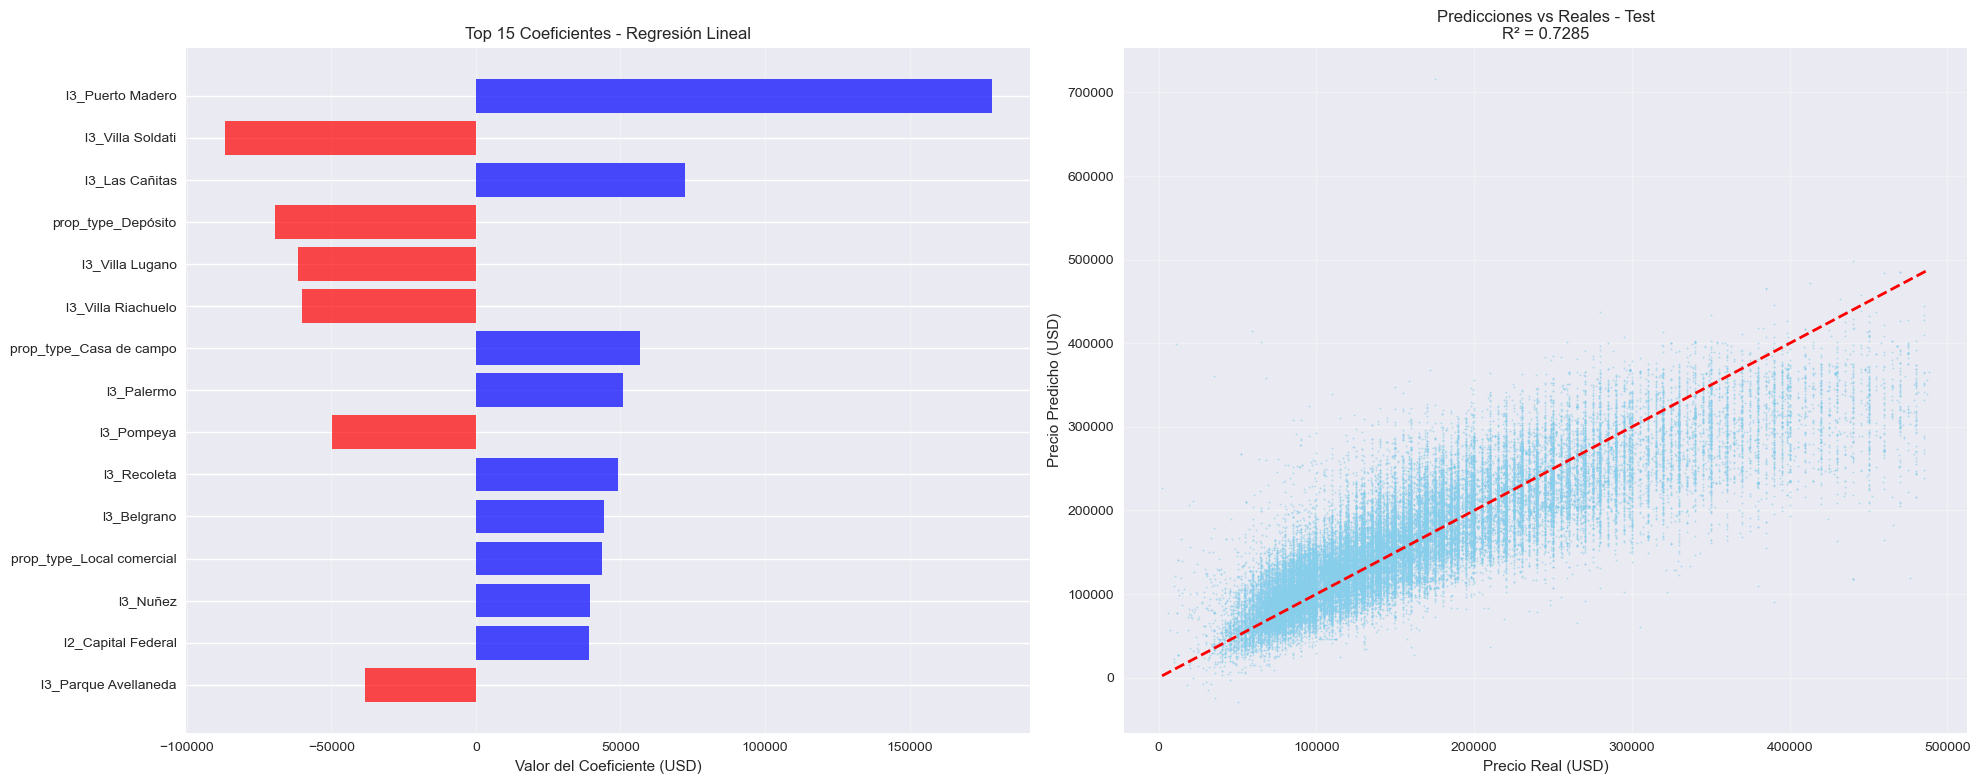

In [34]:
# Visualización de coeficientes
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Top 15 coeficientes
top_coefs = coef_df.head(15)
colors = ['red' if x < 0 else 'blue' for x in top_coefs['Coeficiente']]
axes[0].barh(range(len(top_coefs)), top_coefs['Coeficiente'], color=colors, alpha=0.7)
axes[0].set_yticks(range(len(top_coefs)))
axes[0].set_yticklabels(top_coefs['Variable'], fontsize=10)
axes[0].set_xlabel('Valor del Coeficiente (USD)')
axes[0].set_title('Top 15 Coeficientes - Regresión Lineal')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Predicciones vs reales (Test)
axes[1].scatter(y_test, y_pred_test_lr, alpha=0.5, s=1, color='skyblue')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Precio Real (USD)')
axes[1].set_ylabel('Precio Predicho (USD)')
axes[1].set_title(f'Predicciones vs Reales - Test\nR² = {lr_metrics_test["R2_Test"]:.4f}')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 🎯 3. Modelo LASSO con Regularización

### 3.1 Optimización de Hiperparámetros

In [35]:
# Optimización de alpha con validación cruzada
print("🔄 OPTIMIZANDO HIPERPARÁMETRO ALPHA PARA LASSO")
print("=" * 60)

# Rango de alphas a probar (logarítmico)
alphas = np.logspace(-4, 3, 70)  # De 0.0001 a 1000
print(f"Probando {len(alphas)} valores de alpha de {alphas.min():.6f} a {alphas.max():.0f}")

# LassoCV para encontrar alpha óptimo
lasso_cv = LassoCV(
    alphas=alphas, 
    cv=5,  # 5-fold cross validation
    random_state=42, 
    max_iter=2000, 
    n_jobs=-1
)

print("⏳ Ejecutando validación cruzada...")
lasso_cv.fit(X_train_scaled, y_train)

print(f"✅ Optimización completada")
print(f"Alpha óptimo: {lasso_cv.alpha_:.6f}")
print(f"MSE mínimo en CV: {lasso_cv.mse_path_.mean(axis=1).min():,.0f}")

🔄 OPTIMIZANDO HIPERPARÁMETRO ALPHA PARA LASSO
Probando 70 valores de alpha de 0.000100 a 1000
⏳ Ejecutando validación cruzada...
✅ Optimización completada
Alpha óptimo: 96.717986
MSE mínimo en CV: 1,884,780,257
✅ Optimización completada
Alpha óptimo: 96.717986
MSE mínimo en CV: 1,884,780,257


### 3.2 Entrenamiento y Evaluación del Modelo Final

In [36]:
# Entrenar LASSO con alpha óptimo
print("🔄 ENTRENANDO MODELO LASSO FINAL")
print("=" * 40)

lasso_model = Lasso(alpha=lasso_cv.alpha_, max_iter=2000, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

# Generar predicciones
y_pred_train_lasso = lasso_model.predict(X_train_scaled)
y_pred_test_lasso = lasso_model.predict(X_test_scaled)

# Calcular métricas
lasso_metrics_train = calculate_metrics(y_train, y_pred_train_lasso, "Train")
lasso_metrics_test = calculate_metrics(y_test, y_pred_test_lasso, "Test")

print("📊 RESULTADOS LASSO")
print("=" * 30)
print(f"Alpha utilizado:     {lasso_cv.alpha_:.6f}")
print(f"RMSE Entrenamiento: ${lasso_metrics_train['RMSE_Train']:,.0f}")
print(f"RMSE Prueba:        ${lasso_metrics_test['RMSE_Test']:,.0f}")
print(f"MAE Entrenamiento:  ${lasso_metrics_train['MAE_Train']:,.0f}")
print(f"MAE Prueba:         ${lasso_metrics_test['MAE_Test']:,.0f}")
print(f"R² Entrenamiento:   {lasso_metrics_train['R2_Train']:.4f}")
print(f"R² Prueba:          {lasso_metrics_test['R2_Test']:.4f}")

# Análisis de overfitting
overfitting_ratio_lasso = lasso_metrics_test['RMSE_Test'] / lasso_metrics_train['RMSE_Train']
print(f"Ratio Overfitting:  {overfitting_ratio_lasso:.3f}")

# Análisis de selección de variables
non_zero_coefs = np.sum(lasso_model.coef_ != 0)
zero_coefs = np.sum(lasso_model.coef_ == 0)
total_coefs = len(lasso_model.coef_)

print(f"\n🔍 SELECCIÓN DE VARIABLES:")
print(f"Variables mantenidas:  {non_zero_coefs}")
print(f"Variables eliminadas:  {zero_coefs}")
print(f"% Variables eliminadas: {zero_coefs/total_coefs*100:.1f}%")

# Guardar resultados y metadatos en YAML usando función centralizada
resultados_lasso = {
    'modelo': 'LASSO',
    'tipo': 'tradicional',
    'hiperparametros': {
        'alpha': float(lasso_cv.alpha_),
        'max_iter': 2000,
        'random_state': 42
    },
    'n_features': int(non_zero_coefs),
    'total_features': int(total_coefs),
    'metricas': {
        'train': {
            'RMSE': float(lasso_metrics_train['RMSE_Train']),
            'MAE': float(lasso_metrics_train['MAE_Train']),
            'R2': float(lasso_metrics_train['R2_Train'])
        },
        'test': {
            'RMSE': float(lasso_metrics_test['RMSE_Test']),
            'MAE': float(lasso_metrics_test['MAE_Test']),
            'R2': float(lasso_metrics_test['R2_Test'])
        },
        'overfitting_ratio': float(overfitting_ratio_lasso)
    },
    'notebook': '02_modelos_tradicionales.ipynb'
}

# Guardar usando función centralizada
save_result_to_yaml(resultados_lasso)

🔄 ENTRENANDO MODELO LASSO FINAL
📊 RESULTADOS LASSO
Alpha utilizado:     96.717986
RMSE Entrenamiento: $43,366
RMSE Prueba:        $42,966
MAE Entrenamiento:  $31,105
MAE Prueba:         $30,870
R² Entrenamiento:   0.7285
R² Prueba:          0.7284
Ratio Overfitting:  0.991

🔍 SELECCIÓN DE VARIABLES:
Variables mantenidas:  77
Variables eliminadas:  16
% Variables eliminadas: 17.2%
💾 Guardando modelo: LASSO
✅ Resultados guardados en resultados_modelos_tradicionales.yaml
📊 Total de entradas en archivo: 3
📊 RESULTADOS LASSO
Alpha utilizado:     96.717986
RMSE Entrenamiento: $43,366
RMSE Prueba:        $42,966
MAE Entrenamiento:  $31,105
MAE Prueba:         $30,870
R² Entrenamiento:   0.7285
R² Prueba:          0.7284
Ratio Overfitting:  0.991

🔍 SELECCIÓN DE VARIABLES:
Variables mantenidas:  77
Variables eliminadas:  16
% Variables eliminadas: 17.2%
💾 Guardando modelo: LASSO
✅ Resultados guardados en resultados_modelos_tradicionales.yaml
📊 Total de entradas en archivo: 3


In [37]:
# Análisis de coeficientes LASSO
lasso_coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': lasso_model.coef_,
    'Abs_Coef': np.abs(lasso_model.coef_)
}).sort_values('Abs_Coef', ascending=False)

# Variables mantenidas (coeficiente != 0)
selected_vars = lasso_coef_df[lasso_coef_df['Coeficiente'] != 0].copy()
eliminated_vars = lasso_coef_df[lasso_coef_df['Coeficiente'] == 0]['Variable'].tolist()

print("🎯 ANÁLISIS DE VARIABLES SELECCIONADAS - LASSO")
print("=" * 60)

print(f"📊 TOP 15 VARIABLES SELECCIONADAS:")
for idx, row in selected_vars.head(15).iterrows():
    signo = "+" if row['Coeficiente'] > 0 else ""
    print(f"{row['Variable']:25} {signo}{row['Coeficiente']:8.3f}")

print(f"\n🗑️ EJEMPLOS DE VARIABLES ELIMINADAS:")
if eliminated_vars:
    print("Variables con coeficiente = 0 (regularización):")
    for i, var in enumerate(eliminated_vars[:10], 1):
        print(f"  {i:2d}. {var}")
    if len(eliminated_vars) > 10:
        print(f"  ... y {len(eliminated_vars) - 10} variables más")
else:
    print("LASSO no eliminó ninguna variable")

# Comparación de importancia
print(f"\n🔄 COMPARACIÓN DE SELECCIÓN:")
print(f"Regresión Lineal usa: {len(X.columns)} variables")
print(f"LASSO seleccionó:     {non_zero_coefs} variables")
print(f"Reducción de modelo:  {zero_coefs/total_coefs*100:.1f}%")
print(f"Efecto en rendimiento: {abs(lasso_metrics_test['R2_Test'] - lr_metrics_test['R2_Test']):.4f} diferencia en R²")

🎯 ANÁLISIS DE VARIABLES SELECCIONADAS - LASSO
📊 TOP 15 VARIABLES SELECCIONADAS:
surface_total             +49878.413
l3_Palermo                +16972.284
l3_Puerto Madero          +14134.579
bathrooms                 +13806.368
l3_Belgrano               +11434.160
l3_Recoleta               +10326.542
prop_type_Departamento    +6683.980
l3_Barrio Norte           +6449.991
l3_Nuñez                  +6270.187
rooms                     +5618.337
l3_Las Cañitas            +4363.063
l3_Villa Lugano           -4342.845
l3_Balvanera              -3989.820
l3_Villa Urquiza          +3735.611
l3_Flores                 -3166.140

🗑️ EJEMPLOS DE VARIABLES ELIMINADAS:
Variables con coeficiente = 0 (regularización):
   1. l3_Villa Ortuzar
   2. l3_Villa Pueyrredón
   3. l3_General San Martín
   4. l3_Ituzaingó
   5. l3_Lomas de Zamora
   6. l3_Morón
   7. prop_type_Cochera
   8. l3_Parque Chas
   9. l3_Zona Portuaria
  10. l3_Pilar
  ... y 6 variables más

🔄 COMPARACIÓN DE SELECCIÓN:
Regresión Linea

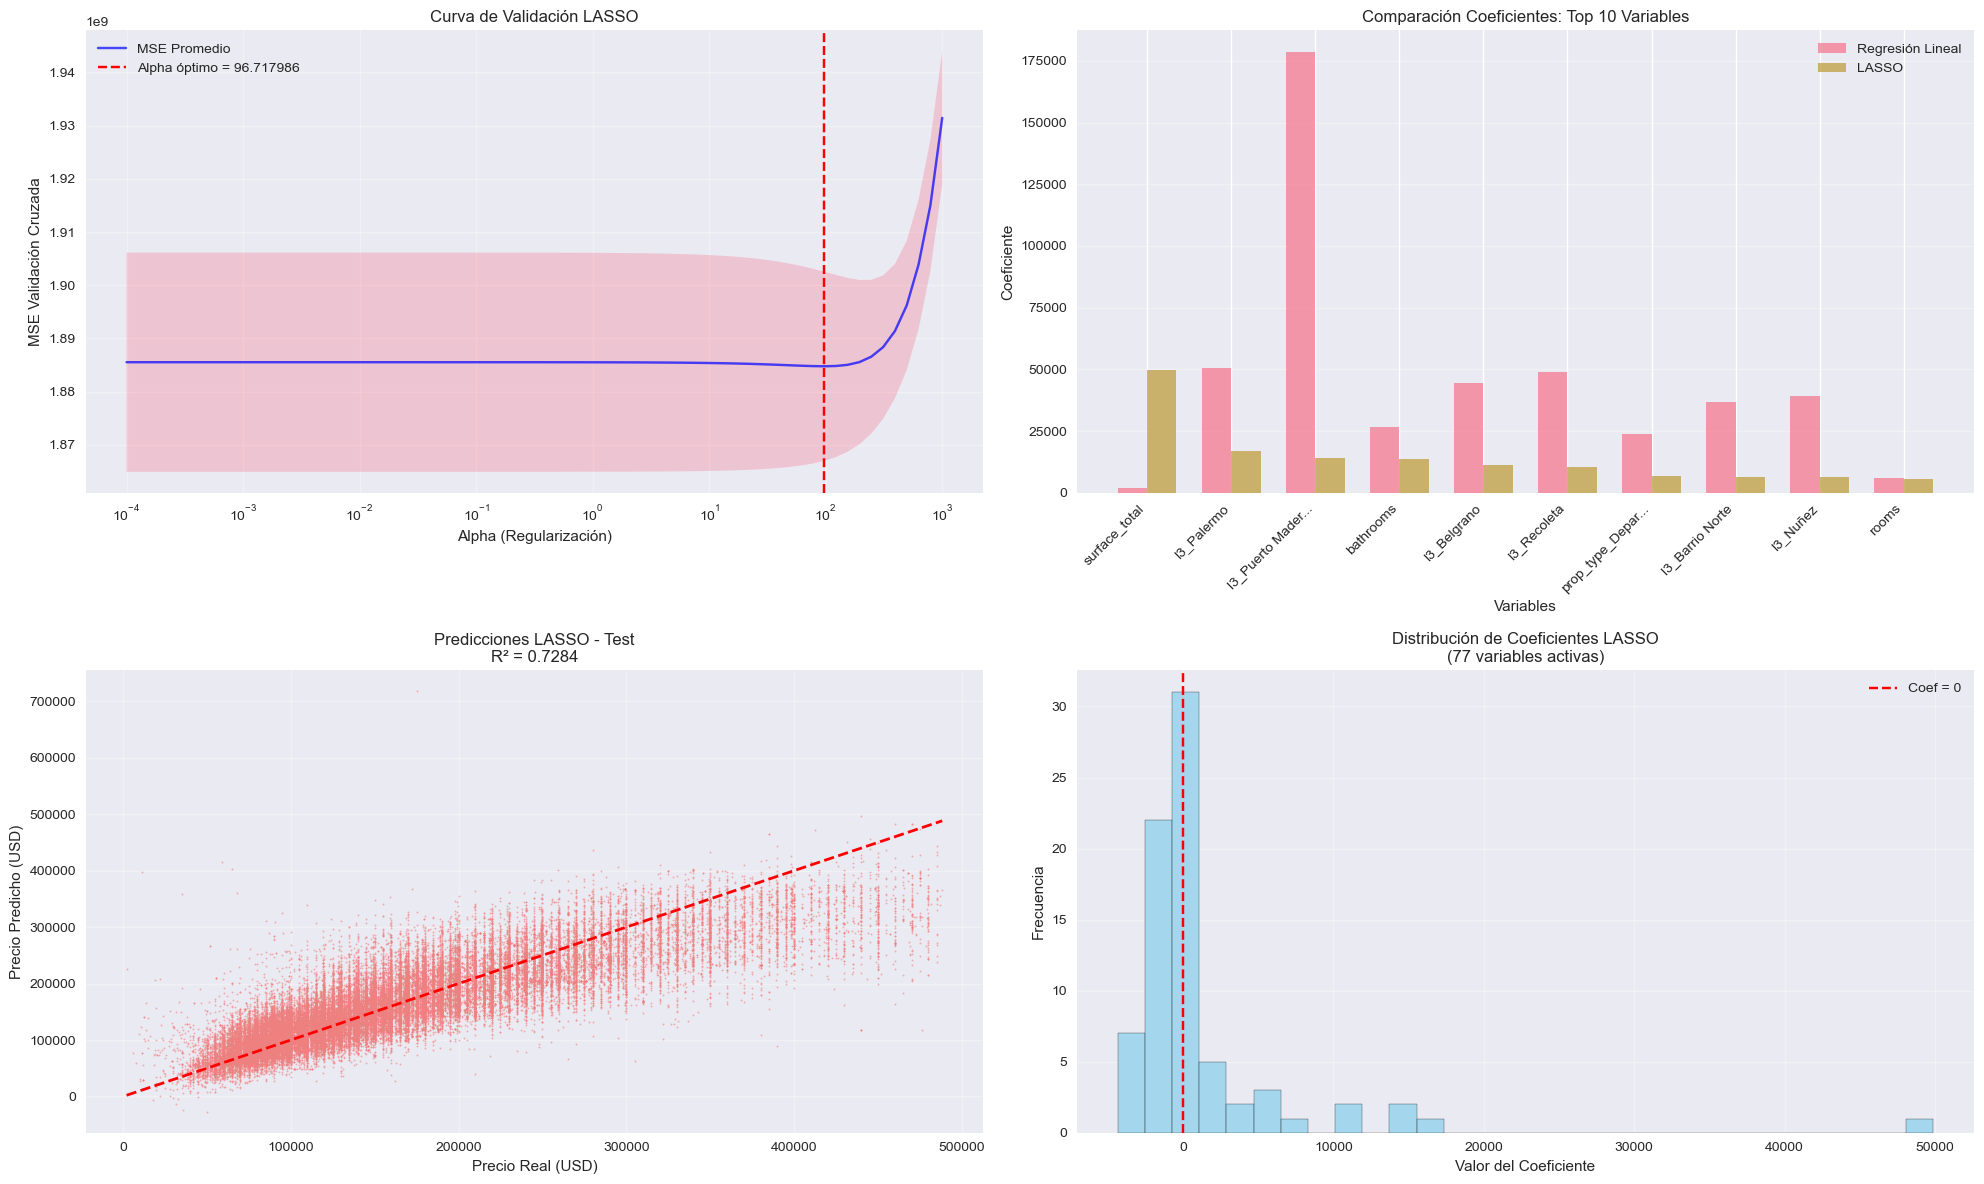

In [38]:
# Visualización de resultados LASSO
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Curva de validación (alpha)
axes[0,0].semilogx(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=1), 'b-', alpha=0.7, label='MSE Promedio')
axes[0,0].fill_between(lasso_cv.alphas_, 
                       lasso_cv.mse_path_.mean(axis=1) - lasso_cv.mse_path_.std(axis=1),
                       lasso_cv.mse_path_.mean(axis=1) + lasso_cv.mse_path_.std(axis=1),
                       alpha=0.3)
axes[0,0].axvline(lasso_cv.alpha_, color='red', linestyle='--', label=f'Alpha óptimo = {lasso_cv.alpha_:.6f}')
axes[0,0].set_xlabel('Alpha (Regularización)')
axes[0,0].set_ylabel('MSE Validación Cruzada')
axes[0,0].set_title('Curva de Validación LASSO')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Coeficientes LASSO vs Regresión Lineal
top_vars = selected_vars.head(10)['Variable'].tolist()
lr_coefs_top = [coef_df[coef_df['Variable'] == var]['Coeficiente'].iloc[0] for var in top_vars]
lasso_coefs_top = [selected_vars[selected_vars['Variable'] == var]['Coeficiente'].iloc[0] for var in top_vars]

x_pos = np.arange(len(top_vars))
width = 0.35
axes[0,1].bar(x_pos - width/2, lr_coefs_top, width, label='Regresión Lineal', alpha=0.7)
axes[0,1].bar(x_pos + width/2, lasso_coefs_top, width, label='LASSO', alpha=0.7)
axes[0,1].set_xlabel('Variables')
axes[0,1].set_ylabel('Coeficiente')
axes[0,1].set_title('Comparación Coeficientes: Top 10 Variables')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels([var[:15] + '...' if len(var) > 15 else var for var in top_vars], rotation=45, ha='right')
axes[0,1].legend()
axes[0,1].grid(axis='y', alpha=0.3)

# Predicciones LASSO
axes[1,0].scatter(y_test, y_pred_test_lasso, alpha=0.5, s=1, color='lightcoral')
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Precio Real (USD)')
axes[1,0].set_ylabel('Precio Predicho (USD)')
axes[1,0].set_title(f'Predicciones LASSO - Test\nR² = {lasso_metrics_test["R2_Test"]:.4f}')
axes[1,0].grid(alpha=0.3)

# Distribución de coeficientes
axes[1,1].hist(selected_vars['Coeficiente'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,1].axvline(0, color='red', linestyle='--', label='Coef = 0')
axes[1,1].set_xlabel('Valor del Coeficiente')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].set_title(f'Distribución de Coeficientes LASSO\n({non_zero_coefs} variables activas)')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 📊 4. Comparación Final de Modelos

### 4.1 Evaluación Comparativa

In [39]:
# Tabla comparativa completa
comparison_data = {
    'Modelo': ['Regresión Lineal', 'LASSO'],
    'RMSE_Train': [lr_metrics_train['RMSE_Train'], lasso_metrics_train['RMSE_Train']],
    'RMSE_Test': [lr_metrics_test['RMSE_Test'], lasso_metrics_test['RMSE_Test']],
    'MAE_Train': [lr_metrics_train['MAE_Train'], lasso_metrics_train['MAE_Train']],
    'MAE_Test': [lr_metrics_test['MAE_Test'], lasso_metrics_test['MAE_Test']],
    'R2_Train': [lr_metrics_train['R2_Train'], lasso_metrics_train['R2_Train']],
    'R2_Test': [lr_metrics_test['R2_Test'], lasso_metrics_test['R2_Test']],
    'Overfitting_Ratio': [overfitting_ratio_lr, overfitting_ratio_lasso],
    'N_Features': [len(X.columns), non_zero_coefs],
    'Alpha': ['-', f'{lasso_cv.alpha_:.6f}']
}

comparison_df = pd.DataFrame(comparison_data)

print("📊 COMPARACIÓN FINAL DE MODELOS TRADICIONALES")
print("=" * 80)
display(comparison_df.round(4))

# Identificar mejor modelo
best_model_idx = comparison_df['RMSE_Test'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Modelo']
best_rmse = comparison_df.loc[best_model_idx, 'RMSE_Test']
best_r2 = comparison_df.loc[best_model_idx, 'R2_Test']

print(f"\n🏆 MEJOR MODELO TRADICIONAL: {best_model_name}")
print(f"📊 Métricas del ganador:")
print(f"   RMSE Test: ${best_rmse:,.0f}")
print(f"   R² Test:   {best_r2:.4f}")
print(f"   Variables: {comparison_df.loc[best_model_idx, 'N_Features']}")

# Análisis de diferencias
rmse_diff = abs(comparison_df.loc[0, 'RMSE_Test'] - comparison_df.loc[1, 'RMSE_Test'])
r2_diff = abs(comparison_df.loc[0, 'R2_Test'] - comparison_df.loc[1, 'R2_Test'])

print(f"\n📈 ANÁLISIS DE DIFERENCIAS:")
print(f"Diferencia RMSE: ${rmse_diff:,.0f} ({rmse_diff/comparison_df['RMSE_Test'].mean()*100:.3f}%)")
print(f"Diferencia R²:   {r2_diff:.4f}")
print(f"Reducción de variables LASSO: {zero_coefs} ({zero_coefs/total_coefs*100:.1f}%)")

if rmse_diff < 1000:
    print("✅ Rendimiento prácticamente idéntico entre modelos")
else:
    print("⚠️ Diferencia notable en rendimiento")

# Guardar resumen comparativo usando función centralizada
resumen_comparativo = {
    'comparacion_tradicionales': {
        'modelos': ['Regresión Lineal', 'LASSO'],
        'mejor_modelo': best_model_name,
        'mejor_rmse': float(best_rmse),
        'mejor_r2': float(best_r2),
        'diferencia_rmse': float(rmse_diff),
        'diferencia_r2': float(r2_diff),
        'tabla_completa': comparison_df.round(4).to_dict(orient='records'),
        'notebook': '02_modelos_tradicionales.ipynb'
    }
}

# Guardar usando función centralizada
save_result_to_yaml(resumen_comparativo)

📊 COMPARACIÓN FINAL DE MODELOS TRADICIONALES


,Modelo,RMSE_Train,RMSE_Test,MAE_Train,MAE_Test,R2_Train,R2_Test,Overfitting_Ratio,N_Features,Alpha
0,Regresión Lineal,43356.8836,42959.6125,31155.9665,30921.8660,0.7286,0.7285,0.9908,93,-
1,LASSO,43365.5402,42965.7384,31105.1426,30869.7329,0.7285,0.7284,0.9908,77,96.717986



🏆 MEJOR MODELO TRADICIONAL: Regresión Lineal
📊 Métricas del ganador:
   RMSE Test: $42,960
   R² Test:   0.7285
   Variables: 93

📈 ANÁLISIS DE DIFERENCIAS:
Diferencia RMSE: $6 (0.014%)
Diferencia R²:   0.0001
Reducción de variables LASSO: 16 (17.2%)
✅ Rendimiento prácticamente idéntico entre modelos
💾 Guardando resumen comparativo
✅ Resultados guardados en resultados_modelos_tradicionales.yaml
📊 Total de entradas en archivo: 3


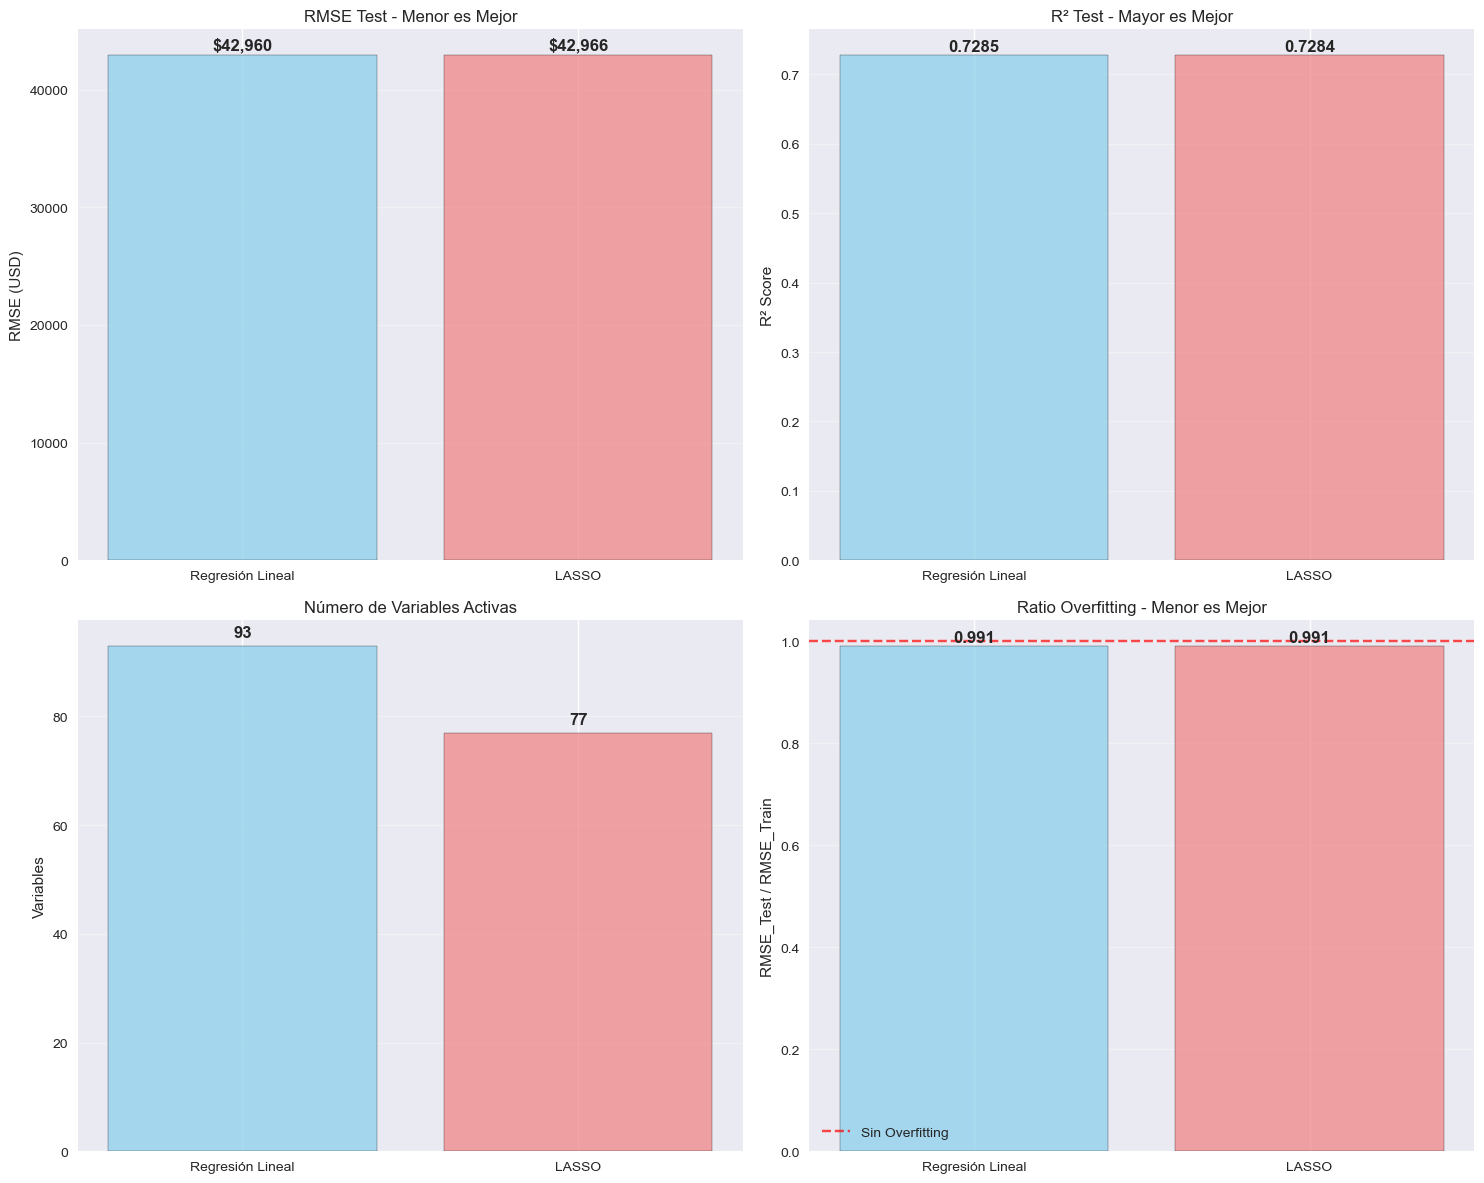


📋 RESUMEN EJECUTIVO - MODELOS TRADICIONALES
✅ Baseline establecido con éxito:
   • Mejor RMSE:     $42,960
   • Mejor R²:       0.7285
   • Varianza explicada: 72.8%

🎯 Características del mejor modelo (Regresión Lineal):
   • Todas las variables contribuyen
   • Interpretabilidad completa

🚀 Próximos pasos:
   • Implementar modelos de ML avanzados
   • Objetivo: superar RMSE de $42,960
   • Explorar relaciones no lineales


In [40]:
# Visualización comparativa final
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# RMSE Comparación
models = comparison_df['Modelo']
rmse_values = comparison_df['RMSE_Test']
colors = ['skyblue', 'lightcoral']

bars1 = axes[0,0].bar(models, rmse_values, color=colors, alpha=0.7, edgecolor='black')
axes[0,0].set_title('RMSE Test - Menor es Mejor')
axes[0,0].set_ylabel('RMSE (USD)')
axes[0,0].grid(axis='y', alpha=0.3)
for i, v in enumerate(rmse_values):
    axes[0,0].text(i, v + 200, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold')

# R² Comparación
r2_values = comparison_df['R2_Test']
bars2 = axes[0,1].bar(models, r2_values, color=colors, alpha=0.7, edgecolor='black')
axes[0,1].set_title('R² Test - Mayor es Mejor')
axes[0,1].set_ylabel('R² Score')
axes[0,1].grid(axis='y', alpha=0.3)
for i, v in enumerate(r2_values):
    axes[0,1].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Número de Variables
n_features = comparison_df['N_Features']
bars3 = axes[1,0].bar(models, n_features, color=colors, alpha=0.7, edgecolor='black')
axes[1,0].set_title('Número de Variables Activas')
axes[1,0].set_ylabel('Variables')
axes[1,0].grid(axis='y', alpha=0.3)
for i, v in enumerate(n_features):
    axes[1,0].text(i, v + 1, f'{v}', ha='center', va='bottom', fontweight='bold')

# Ratio de Overfitting
overfitting_values = comparison_df['Overfitting_Ratio']
bars4 = axes[1,1].bar(models, overfitting_values, color=colors, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Ratio Overfitting - Menor es Mejor')
axes[1,1].set_ylabel('RMSE_Test / RMSE_Train')
axes[1,1].grid(axis='y', alpha=0.3)
axes[1,1].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Sin Overfitting')
for i, v in enumerate(overfitting_values):
    axes[1,1].text(i, v + 0.002, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Resumen ejecutivo
print(f"\n📋 RESUMEN EJECUTIVO - MODELOS TRADICIONALES")
print("=" * 70)
print(f"✅ Baseline establecido con éxito:")
print(f"   • Mejor RMSE:     ${best_rmse:,.0f}")
print(f"   • Mejor R²:       {best_r2:.4f}")
print(f"   • Varianza explicada: {best_r2*100:.1f}%")

print(f"\n🎯 Características del mejor modelo ({best_model_name}):")
if best_model_name == 'LASSO':
    print(f"   • Regularización efectiva (α = {lasso_cv.alpha_:.6f})")
    print(f"   • Selección automática de variables")
    print(f"   • {non_zero_coefs} de {total_coefs} variables mantenidas")
else:
    print(f"   • Todas las variables contribuyen")
    print(f"   • Interpretabilidad completa")

print(f"\n🚀 Próximos pasos:")
print(f"   • Implementar modelos de ML avanzados")
print(f"   • Objetivo: superar RMSE de ${best_rmse:,.0f}")
print(f"   • Explorar relaciones no lineales")